In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
my_path = os.path.abspath('')
my_path = my_path.split('\\')
my_path_py = "\\".join(my_path[:-1])

DF_TOTAL_T=pd.read_csv(my_path_py+'\\DatosRaw\\DEN_2015to2020.csv', sep=',')

In [3]:
listaDistrito = DF_TOTAL_T['Dep-Prov-Distrito'].tolist()
listaDistrito = list(dict.fromkeys(listaDistrito))
print('Son ', len(listaDistrito), ' distritos')
listaDistrito.sort()
#print(listaDistrito)

Son  505  distritos


In [4]:
timeSeries = pd.read_csv(my_path_py+'\\DatosRaw\\SerieTemporal_2015to2020.csv', sep=',')
timeSeries = timeSeries.fillna(0.00001)

## Funciones de Distancias

In [5]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [6]:
n= timeSeries.shape[0]
timeSeries = timeSeries.replace('nan', np.nan).fillna(0.000001)
timeSeries = timeSeries.replace([np.inf, -np.inf], np.nan).fillna(0.000001)

In [7]:
timeSeries.shape

(505, 318)

## Matriz de distancia euclidiana

In [8]:
#Euclidean
euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        euclidean_dist[i,j] = euclidean(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

In [18]:
euclidean_distDF = pd.DataFrame(euclidean_dist)
euclidean_distDF.to_csv('MatrizEuclidiana_RB.csv', index=False)

## Matriz de DTW 

In [9]:
#DTW 
dtw_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        dtw_dist[i,j] = fast_DTW(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())
    

In [19]:
dtw_distDF = pd.DataFrame(dtw_dist)
dtw_distDF.to_csv('MatrizDTW_RB.csv', index=False)

## Matriz de correlación de Pearson

In [10]:
corr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        corr_dist[i,j] = corr(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

<ipython-input-5-af9206df4a85>:66: RuntimeWarning: invalid value encountered in double_scalars
  r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))


In [20]:
corr_distDF = pd.DataFrame(corr_dist)
corr_distDF.to_csv('MatrizPearson_RB.csv', index=False)

## Matriz de correlación de Spearman

In [11]:
#scorr
scorr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        scorr_dist[i,j] = scorr(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [21]:
scorr_distDF = pd.DataFrame(scorr_dist)
scorr_distDF.to_csv('MatrizSpearman_RB.csv', index=False)

## DEFINICIÓN DEL NÚMERO DE CLUSTERS K

In [12]:
k=6

In [13]:
from sklearn.preprocessing import LabelEncoder
DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)
    
    

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    #print("IC",ic_distances)
    if len(ic_distances[ic_distances.nonzero()])==0:
        min_distance = 0
    else:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))
    
    

    return min_distance / max_diameter

In [14]:
import scipy.cluster.hierarchy as hac
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score
HAC_scores=[]
#Experimentos HAC
HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(euclidean_dist)
silhouette_avg=silhouette_score( euclidean_dist, HAC_euc)
print("HAC + euclidian distance: ")
print("SC: ",silhouette_score( euclidean_dist, HAC_euc))
#print("CHZ: ",calinski_harabasz_score(euclidean_dist, HAC_euc))
#print("DUNN: ",dunn(HAC_euc, euclidean_dist, 'farthest', 'farthest'))
#HAC_rmse = AgglomerativeClustering(n_clusters=k).fit_predict(f_rmse_dist)
#print("HAC + rmse distance: ",silhouette_score( f_rmse_dist, HAC_rmse))
HAC_scores.append(silhouette_score(euclidean_dist, HAC_euc))

HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(corr_dist)
print("HAC + corr distance: ")
print("SC: ",silhouette_score(corr_dist, HAC_corr))
#print("CHZ: ",calinski_harabasz_score(corr_dist,HAC_corr))
#print("DUNN: ",dunn(HAC_corr, corr_dist, 'farthest', 'farthest'))
#print("HAC + corr distance: ",0.0)
HAC_scores.append(silhouette_score(corr_dist, HAC_corr))

HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(scorr_dist)
print("HAC + scorr distance: ")
print("SC: ", silhouette_score(scorr_dist, HAC_scorr))
#print("CHZ: ",calinski_harabasz_score(scorr_dist, HAC_scorr))
#print("DUNN: ",dunn(HAC_scorr, scorr_dist, 'farthest', 'farthest'))
HAC_scores.append(silhouette_score(scorr_dist, HAC_scorr))

HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(dtw_dist)
print("HAC + dtw distance: ")
print("SC: ", silhouette_score( dtw_dist, HAC_dtw))
#print("CHZ: ",calinski_harabasz_score(dtw_dist, HAC_dtw))
#print("DUNN: ",dunn(HAC_dtw, dtw_dist, 'farthest', 'farthest'))
HAC_scores.append(silhouette_score(dtw_dist, HAC_dtw))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


HAC + euclidian distance: 
SC:  0.7555016881995027
HAC + corr distance: 
SC:  0.6190350104947174
HAC + scorr distance: 
SC:  0.6126581805138904
HAC + dtw distance: 
SC:  0.6555852325154342


In [15]:
from sklearn.cluster import KMeans, DBSCAN
KM_Scores=[]
km_euc = KMeans(n_clusters=k).fit_predict(euclidean_dist)
silhouette_avg=silhouette_score( euclidean_dist, km_euc)
print("KM + euclidian distance: ")
print("SC: ", silhouette_score(euclidean_dist, km_euc))
KM_Scores.append(silhouette_score(euclidean_dist, km_euc))
#print("CHZ: ",calinski_harabasz_score(euclidean_dist, km_euc))
#print("DUNN: ",dunn(km_euc, euclidean_dist, 'farthest', 'farthest'))
#km_rmse = KMeans(n_clusters=k).fit_predict(rmse_dist)
#print("KM + rmse distance: ")
#print("SC: ",silhouette_score( rmse_dist, km_rmse))
#print("DUNN: ",base.dunn(km_rmse))

km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)
print("KM + corr distance: ")
print("SC: ", silhouette_score(corr_dist, km_corr))
#print("CHZ: ",calinski_harabasz_score(corr_dist, km_corr))
#print("DUNN: ",dunn(km_corr, corr_dist, 'farthest', 'farthest'))
KM_Scores.append(silhouette_score(corr_dist, km_corr))

km_scorr = KMeans(n_clusters=k).fit_predict(scorr_dist)
print("KM + scorr distance: ")
print("SC: ", silhouette_score(scorr_dist, km_scorr))
#print("CHZ: ",calinski_harabasz_score(scorr_dist, km_scorr))
#print("DUNN: ",dunn(km_scorr, scorr_dist, 'farthest', 'farthest'))
KM_Scores.append(silhouette_score(scorr_dist, km_scorr))

km_dtw = KMeans(n_clusters=k).fit_predict(dtw_dist)
print("KM + dtw distance: ")
print("SC: ", silhouette_score(dtw_dist, km_dtw))
#print("CHZ: ",calinski_harabasz_score(dtw_dist, km_dtw))
#print("DUNN: ",dunn(km_dtw, dtw_dist, 'farthest', 'farthest'))
KM_Scores.append(silhouette_score(dtw_dist, km_dtw))


KM + euclidian distance: 
SC:  0.7573501722944306
KM + corr distance: 
SC:  0.6456727940100966
KM + scorr distance: 
SC:  0.6425007198065863
KM + dtw distance: 
SC:  0.6819160798043873


# Experimentos DBSCAN

El puntaje es negativo porque los puntos están en promedio más cerca de otro cluster, que del cuál ha sido asignado

Epsilon máximo:  1.61


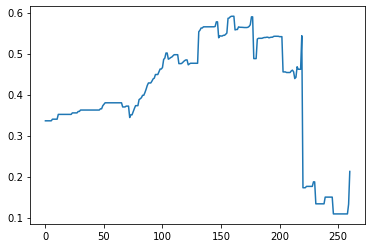

In [26]:
epsilon_lista = np.arange (0.01, 4, 0.01)
sil_list = []
for e in epsilon_lista:
    try:
        DB_corr = DBSCAN(eps=e, min_samples=5).fit_predict(corr_dist)
        sil = silhouette_score(corr_dist, DB_corr)
        sil_list.append(sil)
    except:
        pass
plt.plot(sil_list)
print('Epsilon máximo: ', epsilon_lista[np.argmax(sil_list)])

In [33]:
DB_scores=[]
#CON EUCLIDEAN
DB_euc = DBSCAN(eps=220, min_samples=5).fit_predict(euclidean_dist)
silhouette_avg=silhouette_score( euclidean_dist, DB_euc)
print("DBSCAN + euclidian distance: ")
print("SC: ", silhouette_score( euclidean_dist, DB_euc))
#print("CHZ: ",calinski_harabasz_score(euclidean_dist, DB_euc))
#print("DUNN: ",dunn(DB_euc, euclidean_dist, 'farthest', 'farthest'))
DB_scores.append(silhouette_score(euclidean_dist, DB_euc))

#CON CORRELATION
DB_corr = DBSCAN(eps=1.61, min_samples=5).fit_predict(corr_dist)
print("DBSCAN + corr distance: ")
print("SC: ",silhouette_score(corr_dist, DB_corr))
#print("CHZ: ",calinski_harabasz_score(corr_dist, DB_corr))
#print("DUNN: ",dunn(DB_corr, corr_dist, 'farthest', 'farthest'))
DB_scores.append(silhouette_score(corr_dist, DB_corr))

#CON SPEARMAN
DB_scorr = DBSCAN(eps=1.61, min_samples=5).fit_predict(scorr_dist)
print("DBSCAN + scorr distance: ")
print("SC: ",silhouette_score(scorr_dist, DB_scorr))
#print("CHZ: ",calinski_harabasz_score(scorr_dist, DB_scorr))
#print("DUNN: ",dunn(DB_scorr, scorr_dist, 'farthest', 'farthest'))
DB_scores.append(silhouette_score(scorr_dist, DB_scorr))

#CON D TIME WARPING
DB_dtw = DBSCAN(eps=220, min_samples=5).fit_predict(dtw_dist)
print("DBSCAN + dtw distance: ")
print("SC: ",silhouette_score(dtw_dist, DB_dtw))
#print("CHZ: ",calinski_harabasz_score( dtw_dist, DB_dtw))
#print("DUNN: ",dunn(DB_dtw, dtw_dist, 'farthest', 'farthest'))
DB_scores.append(silhouette_score(dtw_dist, DB_dtw))

DBSCAN + euclidian distance: 
SC:  0.4697821653119887
DBSCAN + corr distance: 
SC:  0.5910680643627789
DBSCAN + scorr distance: 
SC:  0.47330399926543315
DBSCAN + dtw distance: 
SC:  0.2734762544685429


In [38]:
aux2 = pd.DataFrame()
aux2['Dep-Prov-Distrito'] =listaDistrito
aux2['Cluster KM Eu'] = km_euc
aux2['Cluster HAC Eu'] = HAC_euc
aux2['Cluster DB Pear'] = DB_corr
aux2.to_csv('ClusterRB_Peru.csv', index = False)

In [40]:
np.unique(DB_corr)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

In [34]:
df_sc=pd.DataFrame(columns=["Algoritmo", "Euclidean","Pearson Corr","Spearman Corr","DTW"])
HAC_scores.insert(0, 'Hierarchical')
KM_Scores.insert(0, 'KMeans')
DB_scores.insert(0, 'DBSCAN')
df_sc.loc[0]= HAC_scores
df_sc.loc[1]= KM_Scores
df_sc.loc[2]= DB_scores
df_sc

ValueError: cannot set a row with mismatched columns

In [32]:
df_sc.to_csv('SilScoreRB_2015to2020.csv')

hola
